Import all needed libraries and functions

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import sys
import math
sys.path.append("../src") 
from cylinder_phase import cylinder_phase_perp_to_z_3d

def background_fit(phase, mask, deg=1):
    y, x = np.mgrid[0:phase.shape[0], 0:phase.shape[1]]
    x_data, y_data = x[mask], y[mask]
    z_data = phase[mask]
    A = np.vstack([x_data**m * y_data**n for m in range(deg+1) for n in range(deg+1-m)]).T
    coeffs, *_ = np.linalg.lstsq(A, z_data, rcond=None)
    bg = np.zeros_like(phase, dtype=float)
    idx = 0
    for m in range(deg+1):
        for n in range(deg+1-m):
            bg += coeffs[idx] * (x**m) * (y**n)
            idx += 1
    return bg

def additive_noise(phase, sigma, enabled=False):
    if enabled:
        return phase + sigma * np.random.randn(*phase.shape)
    return phase

Starting by defining parameters of the system and image

In [19]:
# Grid (µm/px)
Nx, Ny = 512, 512
px, py = 0.2, 0.2

# Optics
lam   = 0.532     # wavelength (µm)
n_med = 1.33      # medium index
pz    = 0.2       # z step for integration (µm)  

 here the desired shape for test, its parameters and it's refractive index should be determined, this 

In [20]:

# Material: either a scalar, a 2D array n(x,y), or a callable n_obj(X,Y,z)
n_obj = 1.38      

# Activate for cylinder geometry

R = 20.0          # radius (µm)
L = 60.0          # axis length along x (µm); set None for infinite

phi_true, phi_wrapped, tissue_mask, medium_mask  = cylinder_phase_perp_to_z_3d(
    Nx, Ny, px, py,
    R, L,
    lam=lam, n_med=n_med,
    n_obj=n_obj,
    pz=pz
)

phi_wrapped_used = phi_wrapped


Optionally add noise, and apply corrections for background

In [28]:
# Choose wether to use random noisy data or not and choose how noisy it will be 
use_noisy = True  
sigma = 0.1 # How noisy will the data be

# Choose wether to apply correction to the background
apply_correction = True 

plots = [phi_true, phi_wrapped_used]
plots_names = ["Ground Truth Phase (rad)", "Wrapped Phase (rad)"]
n = 2

if use_noisy:
    phi_noisy = additive_noise(phi_true, sigma, enabled=True)
    phi_wrapped_used = additive_noise(phi_wrapped, sigma, enabled=True)
else:
    phi_noisy = None
    phi_wrapped_used = phi_wrapped


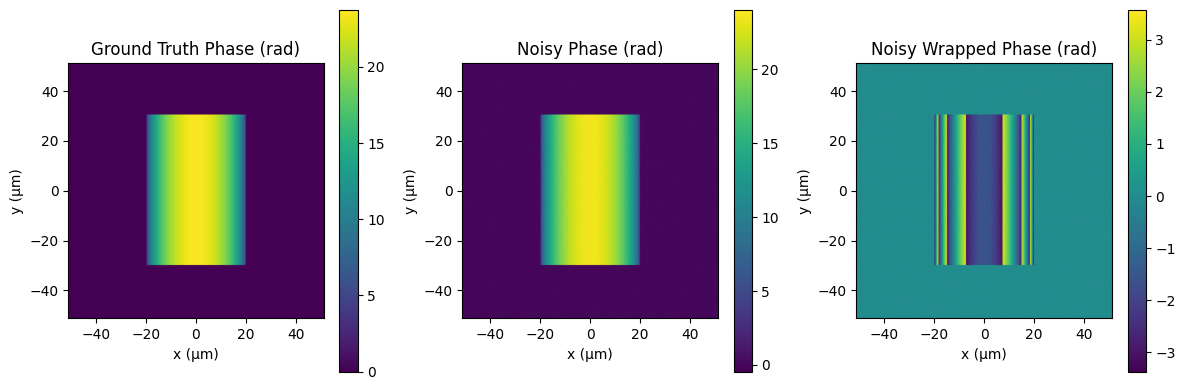

In [29]:
# Build plots list
plots = [phi_true, phi_wrapped_used]
plots_names = ["Ground Truth Phase (rad)", 
               "Noisy Wrapped Phase (rad)" if use_noisy else "Wrapped Phase (rad)"]

if use_noisy:
    plots.insert(1, phi_noisy)
    plots_names.insert(1, "Noisy Phase (rad)")

n = len(plots)

# Plot

fig, axes = plt.subplots(1, n, figsize=(12,4))

for i, (data, name) in enumerate(zip(plots, plots_names)):
    im = axes[i].imshow(data, origin='lower',
                        extent=[-Nx*px/2, Nx*px/2, -Ny*py/2, Ny*py/2])
    axes[i].set_title(name)
    plt.colorbar(im, ax=axes[i])
    axes[i].set_xlabel("x (µm)")
    axes[i].set_ylabel("y (µm)")

plt.tight_layout()

1. First tested algorithm based on 

Miguel Arevallilo Herráez, David R. Burton, Michael J. Lalor, and Munther A. Gdeisat, "Fast two-dimensional phase-unwrapping algorithm based on sorting by reliability following a noncontinuous path," Appl. Opt. 41, 7437-7444 (2002)

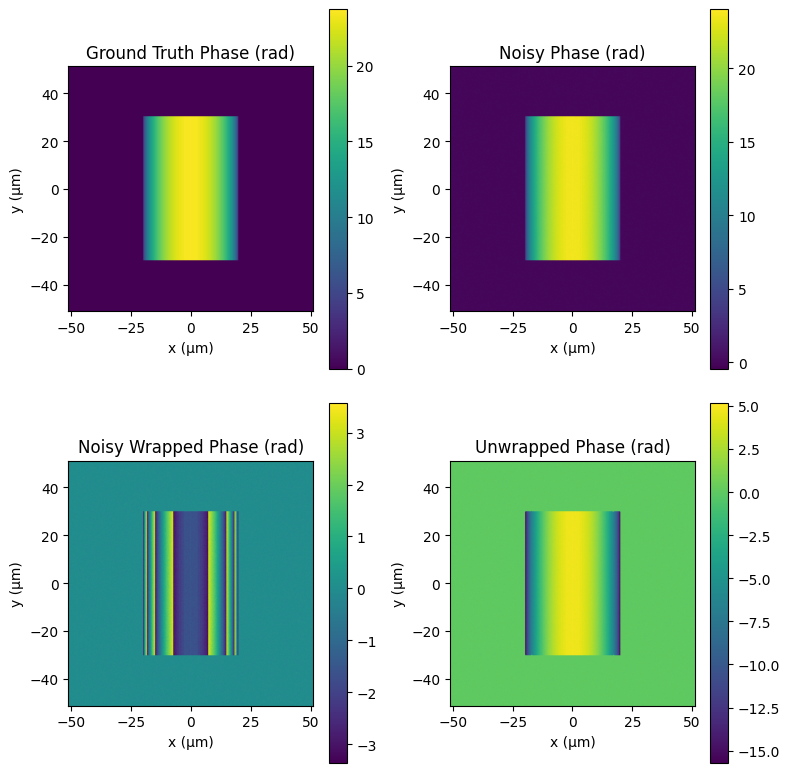

In [30]:
from skimage.restoration import unwrap_phase

"from the package - ability to choose trust worthy pixels"
#mask = np.zeros_like(phi_true, dtype=bool)
#mask[phi_true.shape[0] // 2, :] = True
#phi_unwrapped = unwrap_phase(phi_wrap)

"""
background correction
bg_wrap = background_fit(phi_wrap, medium_mask, deg=1)
phi_wrap_corr = phi_wrap - bg_wrap
unwrapped_for_plot = phi_unwrapped
bg_for_plot   = bg_unwrap
final_for_plot = phi_corrected
if not apply_correction:
    wrap_corr_for_plot = phi_wrap
    final_for_plot     = phi_unwrapped
else:
    wrap_corr_for_plot = phi_wrap_corr
    final_for_plot     = phi_corrected

bg_unwrap = background_fit(phi_unwrapped, medium_mask, deg=1)
phi_corrected = phi_unwrapped - bg_unwrap

"""

# unwrap
phi_unwrapped = unwrap_phase(phi_wrapped_used)

plots.append(phi_unwrapped)
plots_names.append("Unwrapped Phase (rad)")

n = len(plots)

cols = math.ceil(math.sqrt(n))   # columns
rows = math.ceil(n / cols)       # rows

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
axes = axes.ravel()  # flatten to 1D for easy looping

for i, (data, name) in enumerate(zip(plots, plots_names)):
    im = axes[i].imshow(data, origin='lower',
                        extent=[-Nx*px/2, Nx*px/2, -Ny*py/2, Ny*py/2])
    axes[i].set_title(name)
    plt.colorbar(im, ax=axes[i])
    axes[i].set_xlabel("x (µm)")
    axes[i].set_ylabel("y (µm)")

# hide empty subplots if grid > n
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()

plots = [phi_true, phi_wrapped_used]

Evaluation method for the unwrapping mechanism:
1. by substracting unwrapped from ground truth phase
2. by rewraping the unwrapped phase and comparing to wrapped phase

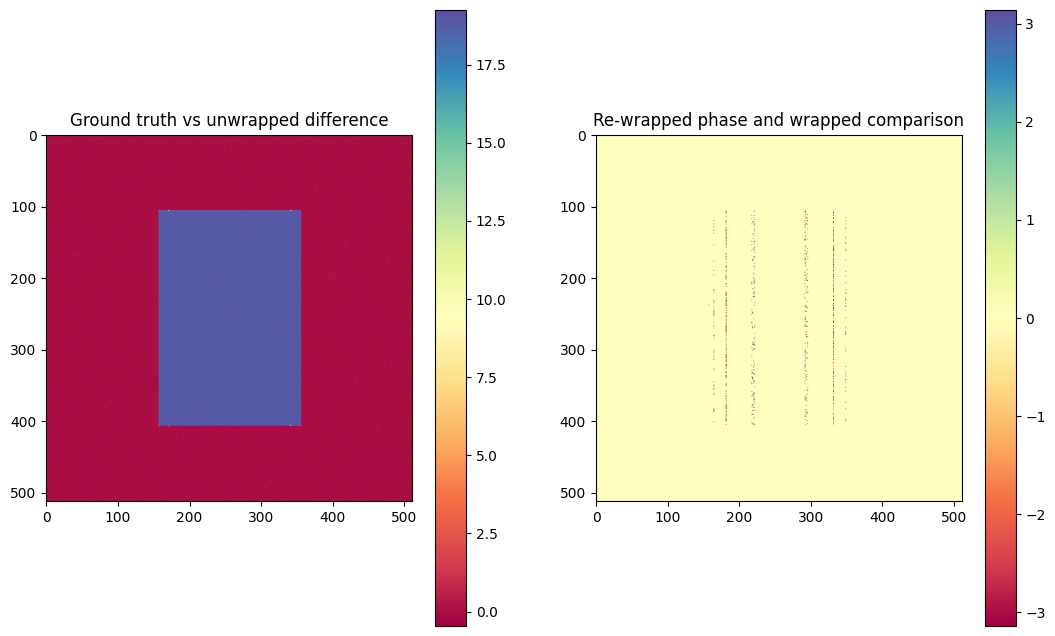

In [32]:
truth_unwrapped_comp = phi_true - phi_unwrapped

rewrapped = phi_rewrapped = np.angle(np.exp(1j * phi_unwrapped))

rewrapped_wrapped_comp = rewrapped - phi_wrapped_used

fig, axes = plt.subplots(1, 2, figsize=(13, 8))

im0 = axes[0].imshow(truth_unwrapped_comp, cmap='Spectral')
axes[0].set_title("Ground truth vs unwrapped difference")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(rewrapped_wrapped_comp, cmap='Spectral', vmin=-np.pi, vmax=np.pi)
axes[1].set_title("Re-wrapped phase and wrapped comparison")
plt.colorbar(im1, ax=axes[1])

